In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from optparse import OptionParser

import pdb
import os
import sys

import h5py
import numpy as np
import pandas as pd
import pyBigWig
import intervaltree
import basenji
import matplotlib.pyplot as plt


# hic imports
import cooler
from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, set_diag, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

import collections 

In [39]:
import cooltools.lib.plotting
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import EngFormatter

In [ ]:
import akita_utils_forplotting as utils
import numpy as np
import pandas as pd
import sys, os, psutil, time 
import matplotlib.pyplot as plt
import pysam

nt = ['A', 'T', 'C', 'G']

In [3]:
#functions from ohther files 
ModelSeq = collections.namedtuple('ModelSeq', ['chr', 'start', 'end', 'label'])

def read_blacklist(blacklist_bed, black_buffer=20):
    """Construct interval trees of blacklist
     regions for each chromosome."""
    black_chr_trees = {}

    if blacklist_bed is not None and os.path.isfile(blacklist_bed):
        for line in open(blacklist_bed):
            a = line.split()
            chrm = a[0]
            start = max(0, int(a[1]) - black_buffer)
            end = int(a[2]) + black_buffer

        if chrm not in black_chr_trees:
            black_chr_trees[chrm] = intervaltree.IntervalTree()

        black_chr_trees[chrm][start:end] = True

    return black_chr_trees


In [ ]:
#TOTAL AKITA INPUT LENGTH 
akita_seq_len=1048576

#HG38 REF FA
hg38_file = '/pollard/home/shzhang/akita/run_akita/refs/hg38.fa'
fasta_hg38 = pysam.Fastafile(hg38_file)

#GENCODE
gene_annot = pd.read_csv('/pollard/data/genetics/GENCODE/release32/gencode.v32.genes_only.bed', sep = '\t', names = ['CHROM', 'start_gene', 'end_gene', 'Gene'])
gene_annot[gene_annot.CHROM != 'chrM']
gene_annot.head()

In [ ]:
#akita plotting functions
def read_fasta(fa):
    '''
    read in fasta file and return sequence only 
    '''   
    seq=''
    with open(fa, "r") as fa_file:
        for line in fa_file:
            if not (line.startswith('>')):
                seq += line.strip()
    fa_file.close()               
    return(seq)   

def mat_from_vector(pred_targets):
    mat = from_upper_triu(pred_targets,seq_len_pool,2)
    #mat = interp_all_nans(mat) 
    return mat

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

In [ ]:
#write separate plotting function so this isn't too messy
#for plotting post akita predictions 

def plot_complex_pred(ALT_mat, REF_mat, ALT_label, REF_label, gene_length):
    print('plotting ' + ALT_label)
    
    #add an option to get bins of gene boundaries based on the gene size 
    bin_start=utils.get_bin(utils.half_patch_size - round(gene_length/2))
    bin_end=utils.get_bin(utils.half_patch_size + round(gene_length/2))
     
    plt.figure(figsize=(8,4))
    target_index = 0
    vmin=-2; vmax=2

    plt.subplot(121) 
    im = plt.matshow(ALT_mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.axvline(x = bin_start, color = 'b', linestyle = '--', linewidth=1, label = 'gene start')
    plt.axvline(x = bin_end, color = 'b', linestyle='--', linewidth=1, label = 'gene end')
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    #plt.title('ALT Prediction' + '\n' + '{} at {}:{}-{}'.format(SVTYPE, CHR, POS, END),y=1.15 )
    plt.title('ALT Prediction: \n ' + ALT_label, y=1.15)

    plt.subplot(122) 
    im = plt.matshow(REF_mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.axvline(x = bin_start, color = 'b', linestyle='--', linewidth=1, label = 'gene start')
    plt.axvline(x = bin_end, color = 'b', linestyle='--', linewidth=1, label = 'gene end')
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('REF Prediction' + '\n' + REF_label, y=1.15 )
    

    plt.tight_layout()
    plt.savefig('{}{}_{}.pdf'.format(fig_dir, date, ALT_label), dpi=300)   # save the figure to file
    plt.close('all')

In [106]:
def make_akita_pred_complex(i):
    print(i)
    bed_name=i[:-3] +'.bed'
    name_parts = i.rsplit('_', 2)

    gencode_coord=gene_annot[gene_annot.Gene == name_parts[1]]    
    gene_len=abs(gencode_coord.end_gene-gencode_coord.start_gene)
    gene_mid_coord=np.floor(gencode_coord.start_gene + (gene_len/2))
    #print('gene mid coord', gene_mid_coord)
    #print('gencode coord', gencode_coord)
    
    #read in bed file and figure out where to center the file 
    bed=pd.read_csv(data_dir+ 'new_fasta/walks.bed/' + bed_name, sep='\t', header=None)
    #rename columns
    bed.columns = ['chr', 'start', 'end', 'strand', '4', '5']
    bed['chr'] = bed['chr'].astype('str') 
    #get spans of each walk 
    bed['span']=abs(bed['end']-bed['start']) 
    #print(bed)
    
    #print('bed span', np.sum(bed['span']))


    #get the row where gene_mid_coord 
    #print(gencode_coord['CHROM'])
    condition = ((bed['chr']==gencode_coord.CHROM.values[0])
                & (bed['start'] <= int(gene_mid_coord)) & (int(gene_mid_coord) <= bed['end']) ) 

    #pd.set_option('display.max_rows', None)
    #print('condition', condition.index[condition])
    #in cases where the middle of the gene shows up more than once, just takes first instance 
    row_midgene = (condition.index[condition].tolist())[0]

    #print('row_midgene index', row_midgene)
        
        

    #get span for the entire walk up to the middle of the gene 
    bed_row=bed.iloc[row_midgene, :]
    #print('bed_Row', bed_row)
    #print('gene row span', np.sum(bed_row['span']))
    #print('gene_mid_Coord', gene_mid_coord)
    if row_midgene>0:
        bed_begin=bed.iloc[0:row_midgene, :]
        #print('bed_begin', bed_begin)
        first_half_span=(np.sum(bed_begin['span'])) + int(gene_mid_coord-bed_row['start'])
        bed_before=pd.concat([bed_begin, bed_row])

    else:
        first_half_span=int(gene_mid_coord-bed_row['start'])
        bed_before=bed_row
    #print('bed_before', bed_row)
            
    #then, get span for entire walk from middle of gene to end 
    if row_midgene<(len(bed)-1):
        bed_end=bed.iloc[(row_midgene+1):len(bed), :]
        #print('bed_end', bed_end)
        second_half_span=(np.sum(bed_end['span'])) + int(bed_row['end']-gene_mid_coord)
    else:
        second_half_span=int(bed_row['end']-gene_mid_coord)
        

        
    #print('first_half_span', first_half_span)
    #print('second half span', second_half_span)
        
    if 1==1:
        
        #read in fasta file 
        seq=read_fasta(data_dir + 'new_fasta/walks.fasta/' + i)
        
        
        #define start and end coordinates of reference matrices
        #currently, just centered around the middle of the gene of interest
        
        CHR = gencode_coord.CHROM.values[0]
        POS = int(gene_mid_coord-utils.half_patch_size)
        END= int(POS+utils.seq_length)
        REF_seq = fasta_hg38.fetch(CHR, POS, END).upper()
     
    
        #define ALT from fasta sequences given to us       
        #check length of walk start to middle of gene, must be at lesat half of akita_seq_len
        mid_seq_idx=0
        if first_half_span>=(utils.half_patch_size):
        
            #get start of ALT sequence 
            ALT_L_start=first_half_span-(utils.half_patch_size)
            ALT_seq_left=seq[ALT_L_start:(ALT_L_start + utils.half_patch_size)]
            mid_seq_idx=(ALT_L_start + utils.half_patch_size)
        else:
            
            #get remainder of sequence from reference
            pad_REF_len=utils.half_patch_size-first_half_span            
            left_REF_pad = fasta_hg38.fetch(bed_row['chr'], bed_row['start']-pad_REF_len, bed_row['start']).upper()
            
            ALT_seq_left=left_REF_pad + seq[0:first_half_span]
            mid_seq_idx=first_half_span
        
        
        if second_half_span>=(utils.half_patch_size):
            #print('alt l start', ALT_L_start)
            ALT_seq_right=seq[mid_seq_idx:(mid_seq_idx + utils.half_patch_size)]
            #print('ALT SEQ RIGHT LEN', len(ALT_seq_right))
                
        else:
            pad_REF_len=utils.half_patch_size-second_half_span            
            right_REF_pad = fasta_hg38.fetch(bed_row['chr'], bed_row['end'], bed_row['end'] + pad_REF_len).upper()
            
            ALT_seq_right=seq[mid_seq_idx:len(seq)] + right_REF_pad
        
        
        #print('ALT SEQ LEFT' , len(ALT_seq_left))
        #print('ALT SEQ RIGHT' , len(ALT_seq_right))
        
        ALT_seq=ALT_seq_left + ALT_seq_right
            
        ####################
        
        assert len(REF_seq) == utils.seq_length, 'REF_seq is not right length'
        assert len(ALT_seq) == utils.seq_length, 'ALT_seq is not right length'
        #print(REF_seq[1:10])
        #print(ALT_seq[1:10])
    
        #this is where akita is actually run, output vector size is (99681,)
        REF_vector, ALT_vector = utils.vector_from_seq(REF_seq), utils.vector_from_seq(ALT_seq)
        REF_mat, ALT_mat = utils.mat_from_vector(REF_vector), utils.mat_from_vector(ALT_vector)
    
        
        print('ref mat size', REF_mat.shape)
        #try to resize
        #resized_refmat = resize(REF_mat, (280000, 280000), anti_aliasing=False)
        #print('ref mat size resize', resized_refmat.shape)

            
        #NOW, PLOT! AND SAVE! 
        ALT_label=i[:-3]
        REF_label='{}:{}-{}'.format(CHR, POS, END)
        plot_complex_pred(ALT_mat, REF_mat, ALT_label, REF_label, gene_len)
            
        
    else:
        #for the input sequences where first half is less than 0.5 Mb, will need to pad the ends 
        #i think we will just assume that we can pull from ref both before and after? 
        #print(i + ' is less than 1Mb in length, will deal with later ')
        
        
        print('error!!!! in file ', i )
        
        
        #if gene center is too close to left or right of chromosome, will throw an error 
            
        #check that total walk length is at least 1Mb
        #if np.sum(bed['span']>akita_seq_len):

In [4]:
data_dir='/pollard/home/shzhang/akita_variant_scoring/akdemir_collab/data/'
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
list_mcool=os.listdir(data_dir + 'mcool/')

In [82]:
print(len(list_mcool))

16


In [83]:
idx_plot=12
resolution=10000
file_plot='mcool/'+list_mcool[idx_plot]

In [84]:
clip=2
crop_bp=0
#sigma 1, width 5
#stddev is sigma
#kernel_size (which i added) is width, i think 
kernel_stddev=0
#kernel_size=5
pool_width=resolution
no_log=False
crop=False
as_obsexp=True
global_obsexp=False
diagonal_offset=2
#options are KR, VC, VC_SQRT
norm_type='VC_SQRT'

In [85]:
def myceil(x, base=resolution):
    return base * np.ceil(x/base)


test=pd.read_csv(data_dir+'new_fasta/walks.bed/' + 
                 list_mcool[idx_plot].replace('.fa.mcool', '.bed'), sep='\t', header=None)
print('total seq len: ', np.sum(test[2]-test[1]))
len_seq=np.sum(test[2]-test[1])
ceil_len=myceil(len_seq)
print('lenseq, ceil_len: ', len_seq, ceil_len)
                  

total seq len:  2511442
lenseq, ceil_len:  2511442 2520000.0


In [86]:
genome_hic_file = f'{data_dir}/{file_plot}::resolutions/{resolution}'
#bed file of sequences that we want from the initial hic file 
seqs_info= ('12', ceil_len)

#path to where output file should be stored
seqs_hic_file = '/pollard/home/shzhang/test.cool'

In [87]:
# read model sequences
model_seqs = []
model_seqs.append(ModelSeq(seqs_info[0],int(0),int(seqs_info[1]),None))

# compute dimensions
num_seqs = len(model_seqs)
seq_len_nt = model_seqs[0].end - model_seqs[0].start
seq_len_pool = seq_len_nt // pool_width

if crop_bp == 0:
    seq_len_crop = seq_len_pool
else:
    crop_start = crop_bp // pool_width
    crop_end = seq_len_pool - crop_start
    seq_len_crop = seq_len_pool - 2*crop_start

# compute upper triangular indexes
triu_tup = np.triu_indices(seq_len_crop, diagonal_offset)
seq_len_nodiag = seq_len_crop - diagonal_offset
seq_len_hic = seq_len_nodiag*(seq_len_nodiag + 1) // 2


if kernel_stddev > 0:
    # initialize Gaussian kernel
    kernel = Gaussian2DKernel(x_stddev=kernel_stddev)

    #kernel = Gaussian2DKernel(x_stddev=kernel_stddev, x_size=kernel_size)
else:
    kernel = None

In [88]:
# open genome coverage file
genome_hic_cool = cooler.Cooler(genome_hic_file)

if global_obsexp:
    try:
        print('loading by-chromosome expected')
        genome_hic_expected = pd.read_csv(genome_hic_file.replace('.cool','.expected'), sep='\t')
    except:
        print('not found: '+genome_hic_file.replace('cool','expected'))
        raise ValueError('invalid expected file')

#check for "chr" prefix
chr_pre = 'chr1' in genome_hic_cool.chromnames

# assert that resolution matches
assert(pool_width == genome_hic_cool.info['bin-size'])

In [89]:
# initialize sequences coverage file
seqs_hic_open = h5py.File(seqs_hic_file, 'w')
seqs_hic_open.create_dataset('targets', shape=(num_seqs, seq_len_hic), dtype='float16')

# for each model sequence
for si in range(num_seqs):
    mseq = model_seqs[si]
    print(mseq)
    if 1==1:
      # pull hic values
        if chr_pre:
            mseq_str = '%s:%d-%d' % (mseq.chr[3:], mseq.start, mseq.end)
        else:
            mseq_str = '%s:%d-%d' % (mseq.chr, mseq.start, mseq.end)
            #print('mseq_str:', mseq_str)

        seq_hic_raw = genome_hic_cool.matrix(balance=norm_type).fetch(mseq_str)
        seq_hic_nan = np.isnan(seq_hic_raw)
        num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))
      
    
        if num_filtered_bins > (.5*len(seq_hic_nan)):
            print("WARNING: %s >50%% bins filtered, check:  %s. " % (genome_hic_file, mseq_str))

#       # set blacklist to NaNs
#       if mseq.chr in black_chr_trees:
#         for black_interval in black_chr_trees[mseq.chr][mseq.start:mseq.end]:
#           # adjust for sequence indexes
#           black_seq_start = (black_interval.begin - mseq.start)// options.pool_width
#           black_seq_end =   int(  np.ceil( (black_interval.end - mseq.start)/ options.pool_width ) )
#           seq_hic_raw[:,black_seq_start:black_seq_end] = np.nan
#           seq_hic_raw[black_seq_start:black_seq_end,:] = np.nan
#         seq_hic_nan = np.isnan(seq_hic_raw)

      # clip first diagonals and high values
        clipval = np.nanmedian(np.diag(seq_hic_raw,diagonal_offset))
        for i in range(-diagonal_offset+1,diagonal_offset):
            set_diag(seq_hic_raw, clipval, i)
        seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
        seq_hic_raw[seq_hic_nan] = np.nan

      # adaptively coarsegrain based on raw counts
        seq_hic_smoothed = adaptive_coarsegrain(
            seq_hic_raw,
            #use KR in this case 
            genome_hic_cool.matrix(balance=norm_type).fetch(mseq_str),
            cutoff=2, max_levels=8)
        seq_hic_nan = np.isnan(seq_hic_smoothed)
      #todo: pass an option to add a certain pseudocount value, or the minimum nonzero value

        #THIS REQUIRES SOME PREKNOWN EXPECTED HIC COUNTS FILE WHICH WE DON'T HAVE 
        if as_obsexp:
            # compute obs/exp        
            if global_obsexp: # compute global obs/exp
                exp_chr = genome_hic_expected.iloc[ genome_hic_expected['chrom'].values ==mseq.chr][0:seq_len_pool]
                if len(exp_chr)==0: 
                      raise ValueError('no expected values found for chr:'+mseq.chr)
                exp_map= np.zeros((seq_len_pool,seq_len_pool))
                for i in range(seq_len_pool):
                    set_diag(exp_map,exp_chr['balanced.avg'].values[i],i)
                    set_diag(exp_map,exp_chr['balanced.avg'].values[i],-i)
                seq_hic_obsexp = seq_hic_smoothed / exp_map
                for i in range(-diagonal_offset+1, diagonal_offset): set_diag(seq_hic_obsexp,1.0,i)
                seq_hic_obsexp[seq_hic_nan] = np.nan          

            else: # compute local obs/exp
                seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]

            # TAKE NATURAL LOG 
            #AND CLIP TO (-2,2)
            #AND ALSO INTERPOLATE 
            if no_log==False:
                seq_hic_obsexp = np.log(seq_hic_obsexp)
                if clip is not None:
                    seq_hic_obsexp = np.clip(seq_hic_obsexp, -clip, clip)
                seq_hic_obsexp = interp_nan(seq_hic_obsexp)
                for i in range(-diagonal_offset+1, diagonal_offset): set_diag(seq_hic_obsexp, 0,i)
        
            else:
                if clip is not None:
                    seq_hic_obsexp = np.clip(seq_hic_obsexp, 0, clip)
                seq_hic_obsexp = interp_nan(seq_hic_obsexp)
                for i in range(-diagonal_offset+1, diagonal_offset): set_diag(seq_hic_obsexp, 1,i)

            # apply kernel
            if kernel is not None:
                seq_hic = convolve(seq_hic_obsexp, kernel)
            else:
                seq_hic = seq_hic_obsexp

        else:
            # interpolate all missing bins
            seq_hic_interpolated = interp_nan(seq_hic_smoothed)

            # rescale, reclip
            seq_hic = 100000*seq_hic_interpolated
            clipval = np.nanmedian(np.diag(seq_hic,diagonal_offset))
            for i in range(-diagonal_offset+1, diagonal_offset):
                set_diag(seq_hic,clipval,i)
            seq_hic = np.clip(seq_hic, 0, clipval)

            #extra smoothing. todo pass kernel specs
            if kernel is not None:
                seq_hic = convolve(seq_hic, kernel)
    else:
    #except ValueError:
        print("WARNING: %s doesn't see %s. Setting to all zeros." % (genome_hic_file, mseq_str))
        seq_hic = np.zeros((seq_len_pool,seq_len_pool), dtype='float16')

    # crop
    if crop_bp > 0:
        seq_hic = seq_hic[crop_start:crop_end,:]
        seq_hic = seq_hic[:,crop_start:crop_end]

    # unroll upper triangular
    seq_hic = seq_hic[triu_tup]
    print(seq_hic.shape)

    # write
    seqs_hic_open['targets'][si,:] = seq_hic.astype('float16')

# close sequences coverage file
seqs_hic_open.close()



ModelSeq(chr='12', start=0, end=2520000, label=None)
(31375,)


/pollard/home/shzhang/miniconda3/envs/akita-working/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


In [90]:
print(seq_len_pool)

252


In [92]:
test_cool=seqs_hic_file

In [93]:
with h5py.File(seqs_hic_file,'r') as h5r:
    hic_map = h5r['targets'][:]
    orig_shape=hic_map.shape
    hic_map=hic_map.reshape(orig_shape[1])
    print(hic_map.shape)


(31375,)


In [94]:
test_mat= mat_from_vector(hic_map)   
print(test_mat.shape)

(252, 252)


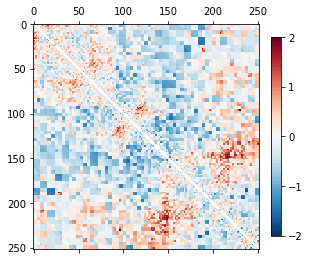

In [95]:
#write separate plotting function so this isn't too messy
#for plotting post akita predictions 


plt.figure(figsize=(8,8))
target_index = 0
vmin=-2; vmax=2

plt.subplot(121) 
im = plt.matshow(test_mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
#plt.title('ALT Prediction' + '\n' + '{} at {}:{}-{}'.format(SVTYPE, CHR, POS, END),y=1.15 )
#plt.title('ALT Prediction: \n ' + ALT_label, y=1.15)
plt.tight_layout()


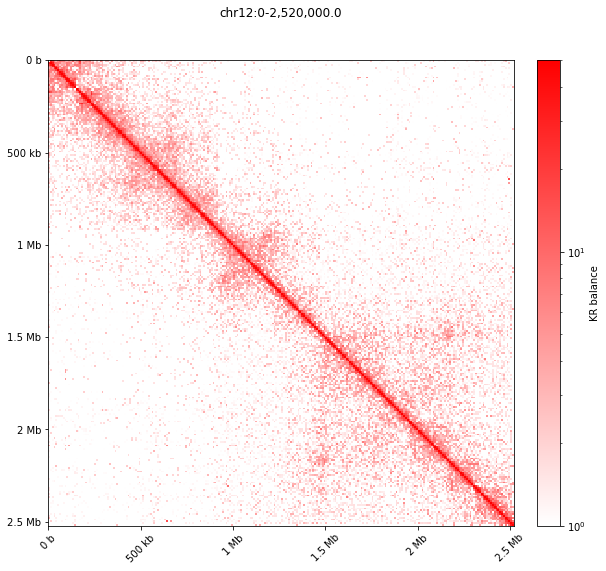

In [110]:
import seaborn as sns
bp_formatter = EngFormatter('b')
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

#read in the same file 
clr = cooler.Cooler(genome_hic_file)



def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

f, ax = plt.subplots(
    figsize=(9,8), ncols=1)

start, end = 0, seqs_info[1]
region = ('12', start, end)
im = ax.matshow(
    #other balance options are VC, VC_SQRT
    clr.matrix(balance='VC_SQRT').fetch(region),
    cmap=fruitpunch,
    #vmax=20,
    norm = LogNorm(vmin=1, vmax=50),
    extent=(start, end, end, start)
);

ax.set_title(f'chr12:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='KR balance');
format_ticks(ax)
plt.tight_layout()

In [97]:
file_to_compare=[list_mcool[idx_plot].replace('.fa.mcool', '.fa')]
file_to_compare

['SMF-12-23_walk_10_MDM2_containing.fa']

In [98]:
#try to compare to akita prediction????? just visually??????

In [102]:
#data directories
date = '202301103'
d='/pollard/home/shzhang/akita_variant_scoring/akdemir_collab/'
data_dir = d + 'data/'
fig_dir = d + 'figs/' + date + '/'

#two folders are colab_fasta and new_fasta

SMF-12-23_walk_10_MDM2_containing.fa
ref mat size (448, 448)
plotting SMF-12-23_walk_10_MDM2_containing


FileNotFoundError: [Errno 2] No such file or directory: '/pollard/home/shzhang/akita_variant_scoring/akdemir_collab/figs/202301103/202301103_SMF-12-23_walk_10_MDM2_containing.pdf'

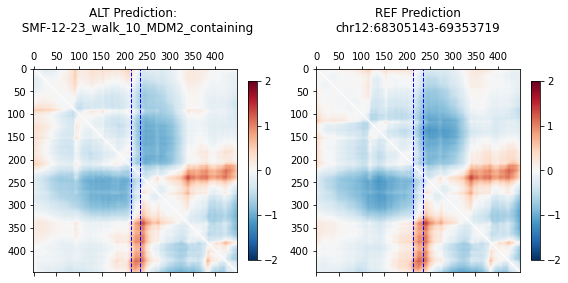

In [109]:
#make akita predictions for each walk and plot 
#for i in os.listdir(data_dir + 'new_fasta/walks.fasta')[1:2]:

i0=file_to_compare[0]
make_akita_pred_complex(i0)
    


In [ ]:
# #args if using commandline 
# """
# akita_data_read.py

# Read and pre-process Hi-C/uC data from cooler.
# """

# ################################################################################
# # main
# ################################################################################
# def main():
#   usage = 'usage: %prog [options] <genome_hic_file> <seqs_bed_file> <seqs_hic_file>'
#   parser = OptionParser(usage)
#   parser.add_option('-b', dest='blacklist_bed',
#       help='Set blacklist nucleotides to a baseline value.')
#   parser.add_option('--clip', dest='clip',
#       default=None, type='float',
#       help='Clip values post-summary to a maximum [Default: %default]')
#   parser.add_option('--crop', dest='crop_bp',
#       default=0, type='int',
#       help='Crop bp off each end [Default: %default]')
#   parser.add_option('-d', dest='diagonal_offset',
#       default=2, type='int',
#       help='Positions on the diagonal to ignore [Default: %default]')
#   parser.add_option('-k', dest='kernel_stddev',
#       default=0, type='int',
#       help='Gaussian kernel stddev to smooth values [Default: %default]')
#   # parser.add_option('-s', dest='scale',
#   #     default=1., type='float',
#   #     help='Scale values by [Default: %default]')
#   parser.add_option('-w',dest='pool_width',
#       default=1, type='int',
#       help='Average pooling width [Default: %default]')
#   parser.add_option('--as_obsexp',dest='as_obsexp',
#       default=False,action="store_true",
#       help='save targets as obsexp profiles')
#   parser.add_option('--global_obsexp',dest='global_obsexp',
#       default=False,action="store_true",
#       help='use global obs/exp')
#   parser.add_option('--no_log',dest='no_log',
#       default=False,action="store_true",
#       help='no not take log for obs/exp')

#   (options, args) = parser.parse_args()